In [1]:
from maxentnuc.analysis.domain_analyzer import DomainAnalyzer
from maxentnuc.analysis.mei_analyzer import MEIAnalyzer
from maxentnuc.analysis.analysis import *
import os
from neighbor_balance.plotting import parse_region, ContactMap, label_comparison, format_ticks, apply_matplotlib_style

apply_matplotlib_style()

No data root found, set manually.


/home/joepaggi/miniconda3/envs/neighbor/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
supercloud = '/home/joepaggi/orcd/scratch'
prod = {
    #'nanog': {'config': f'{supercloud}/mei_runs/nanog/v43/config.yaml', 'iteration': 18},
    'nanog': {'config': f'{supercloud}/mei_runs/nanog/v36/config.yaml', 'iteration': 18},
    'noopt': {'config': f'{supercloud}/mei_runs/nanog/v36/config.yaml', 'iteration': 0},
    #'klf1': {'config': f'{supercloud}/mei_runs/klf1/v3/config.yaml', 'iteration': 11},
   # 'ppm1g': {'config': f'{supercloud}/mei_runs/ppm1g/v2/config.yaml', 'iteration': 10},
    #'sox2': {'config': f'{supercloud}/mei_runs/sox2/v11/config.yaml', 'iteration': 13},
    #'fbn2' : {'config': f'{supercloud}/mei_runs/fbn2/v2/config.yaml', 'iteration': 12},
}

for name in prod:
    prod[name]['mei'] = MEIAnalyzer(prod[name]['config'], scale=0.1)

In [3]:
analyzer = DomainAnalyzer(30, 200)

domains = {}
for name in prod:
    info = prod[name]
    trajectory = info['mei'].get_positions(info['iteration'], skip=110, burnin=0)
    trajectory = trajectory.reshape(-1, *trajectory.shape[-2:])
    domains[name] = analyzer.analyze_trajectory(trajectory)

/home/joepaggi/miniconda3/envs/neighbor/lib/python3.13/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.13/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.13/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as ot

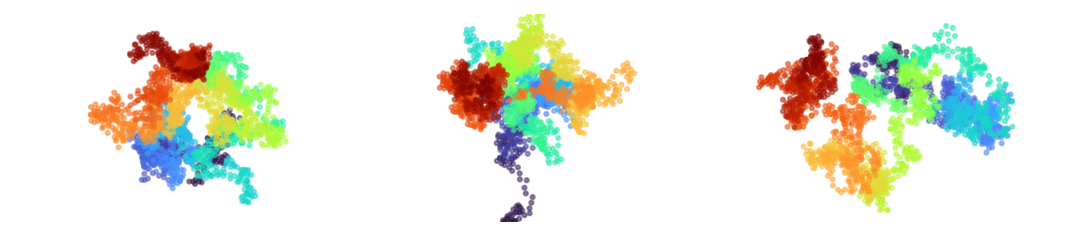

In [4]:
def plot_gallery_list(domains, func=lambda x, ax: x.plot_chain_2D(ax=ax, colorbar=False, s=4), size=500, rows=3, scalebar=500, fname=None):
    assert not len(domains) % rows
    cols = len(domains) // rows
    assert cols < 10

    aspect = 0.6
    size_h = size * aspect
    f, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(3*cols, 3*rows*aspect),
                         gridspec_kw=dict(hspace=0, wspace=0))

    if rows*cols > 1:
        axs = ax.flatten()
    else:
        axs = [ax]
    
    for ax, domain in zip(axs, domains):
        func(domain, ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xlim(-size, size)
        ax.set_ylim(-size_h, size_h)
        ax.axis('off')
        #ax.plot([-scalebar/2, scalebar/2], [size_h/20-size_h, size_h/20-size_h], c='k', solid_capstyle="butt", lw=2)
        
    return f, ax

examples = 3
d = domains['nanog']
d = d[::len(d)//examples][:examples]
plot_gallery_list(d, rows=1, scalebar=200)
plt.savefig('img/overview_gallery.pdf')
plt.show()

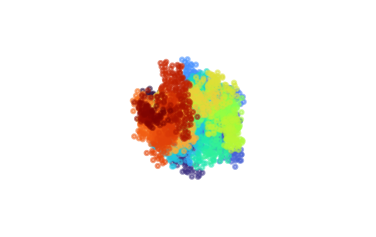

In [5]:
d_noopt = domains['noopt']
d_noopt = d_noopt[-1:]
plot_gallery_list(d_noopt, rows=1, scalebar=200)
plt.savefig('img/overview_noopt_example.pdf')
plt.show()

In [6]:
def plot_horizontal_with_colors(contact_map, extend='min', **kwargs):
    f, ax = plt.subplots(2,  2, figsize=(4, 2.3), sharex='col', gridspec_kw={'width_ratios': [40, 1], 'wspace':0, 'height_ratios': [20, 1], 'hspace': 0.01})
    im = contact_map.plot_contact_map_horizontal(ax=ax[0, 0], depth=end-start, **kwargs, colorbar=False)
    plt.colorbar(im, cax=ax[0, 1], extend=extend)
    pos = ax[0, 1].get_position()
    shrink = 1/3
    ax[0, 1].set_position([pos.x0, pos.y0 + pos.height * (1 - shrink) / 2, pos.width, pos.height*shrink])
    format_ticks(ax[0, 0])
    ax[0, 0].spines[['top', 'left', 'right']].set_visible(False)
    ax[0, 0].set_yticks([])

    ax[1, 0].imshow(np.arange(contact_map.x().shape[0]).reshape(1, -1), extent=(contact_map.start, contact_map.end, 0, 1), cmap='turbo', aspect='auto')
    ax[1, 0].set_yticks([])

    ax[1, 1].axis('off')
    ax[1, 0].locator_params(nbins=7, axis='x')
    return f, ax

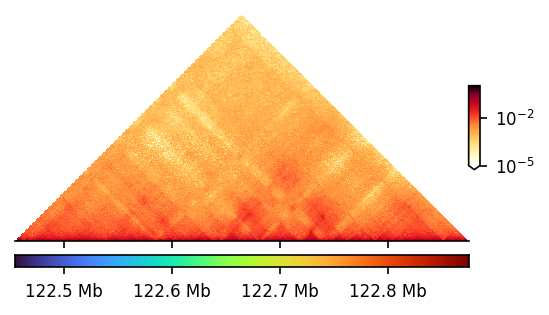

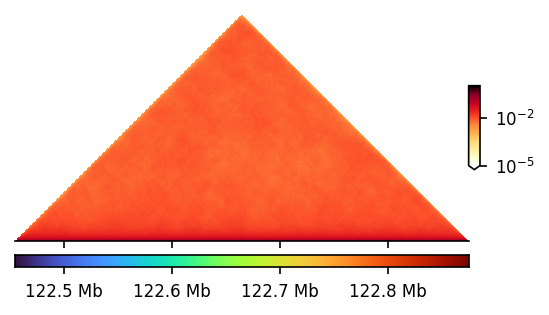

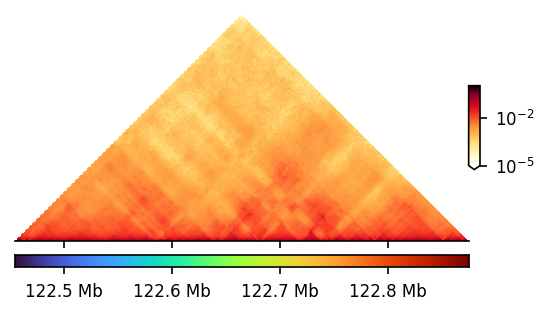

In [7]:
ref_map = prod[name]['mei'].get_reference_contact_map()
noopt_sim_map = prod[name]['mei'].get_precomputed_contact_map(0)
sim_map = prod[name]['mei'].get_precomputed_contact_map(18)

chrom, start, end = parse_region(prod['nanog']['mei'].mei.config['region'])

ref_map = ContactMap(ref_map, chrom, start, end, 200)
noopt_sim_map = ContactMap(noopt_sim_map, chrom, start, end, 200)
sim_map = ContactMap(sim_map, chrom, start, end, 200)

plot_horizontal_with_colors(ref_map)
plt.savefig('img/overview_ref_map.pdf')
plt.show()
plot_horizontal_with_colors(noopt_sim_map)
plt.savefig('img/overview_ensemble_noopt_map.pdf')
plt.show()
plot_horizontal_with_colors(sim_map)
plt.savefig('img/overview_ensemble_map.pdf')
plt.show()

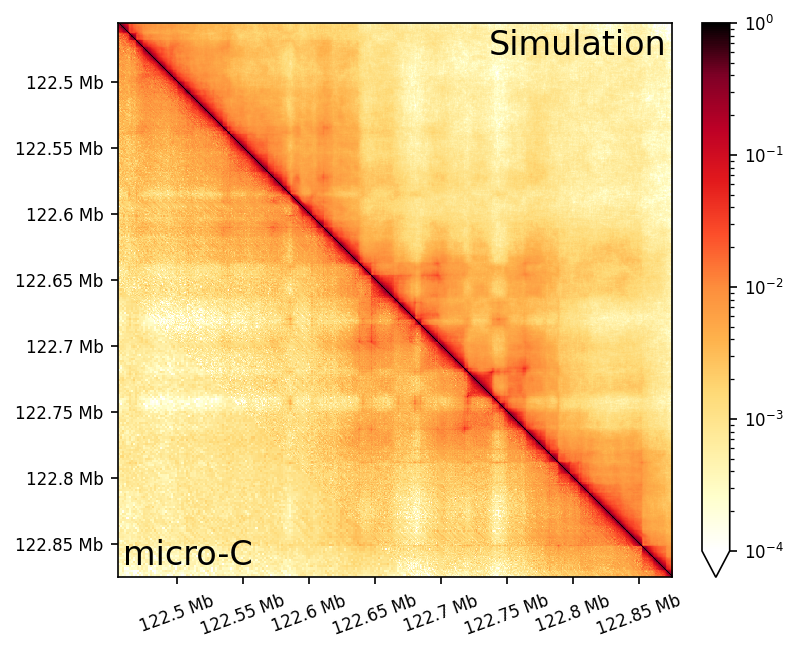

In [8]:
compare = ref_map.copy()
compare.contact_map = np.tril(ref_map.contact_map) + np.triu(sim_map.contact_map, k=1)

f, ax = plt.subplots()
compare.plot_contact_map( vmin=1e-4, ax=ax)
label_comparison(ax, 'Simulation', 'micro-C')
#plt.savefig('overview_ensemble_map.pdf')
plt.show()

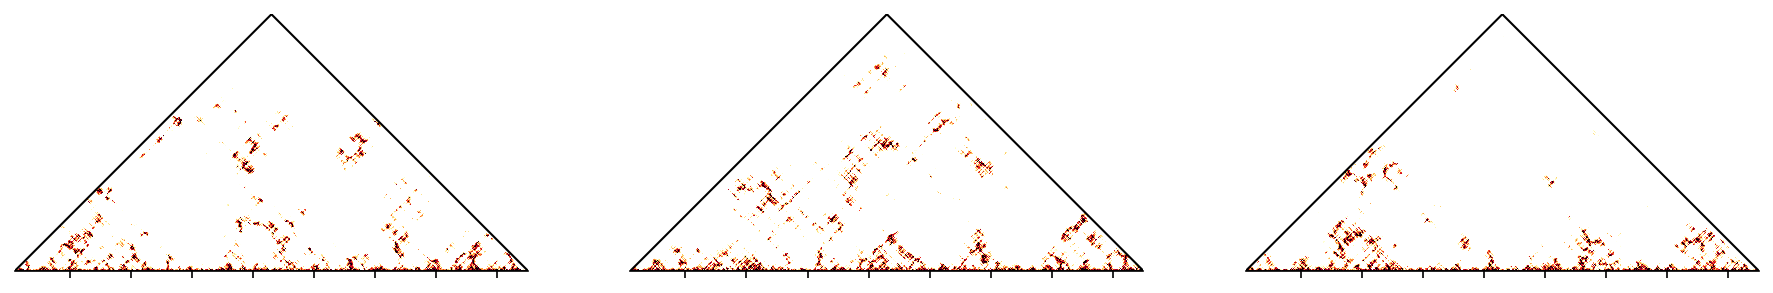

In [9]:
from maxentnuc.simulation.simulated_contacts import contact_indicator

f, ax = plt.subplots(1, examples, figsize=(5*examples, 3))
for i, domain in enumerate(d):
    distances = get_distance_matrix(domain.positions)
    contacts = contact_indicator(distances, tanh_r_c=42, tanh_sigma=0.09523809523809523)
    contacts = ContactMap(contacts, chrom, start, end, 200)
    contacts.plot_contact_map_horizontal(ax=ax[i], depth=end-start, vmin=1e-4, colorbar=False)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].spines[['top', 'left', 'right']].set_visible(False)
    ax[i].plot([start, (end+start)/2], [0, end-start], c='k', lw=1)
    ax[i].plot([(end+start)/2, end], [end-start, 0], c='k', lw=1)
plt.savefig('img/overview_single_map.pdf')
plt.show()

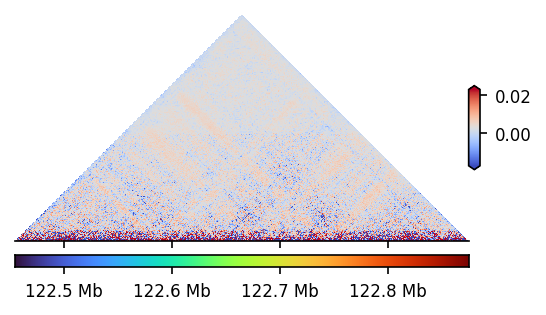

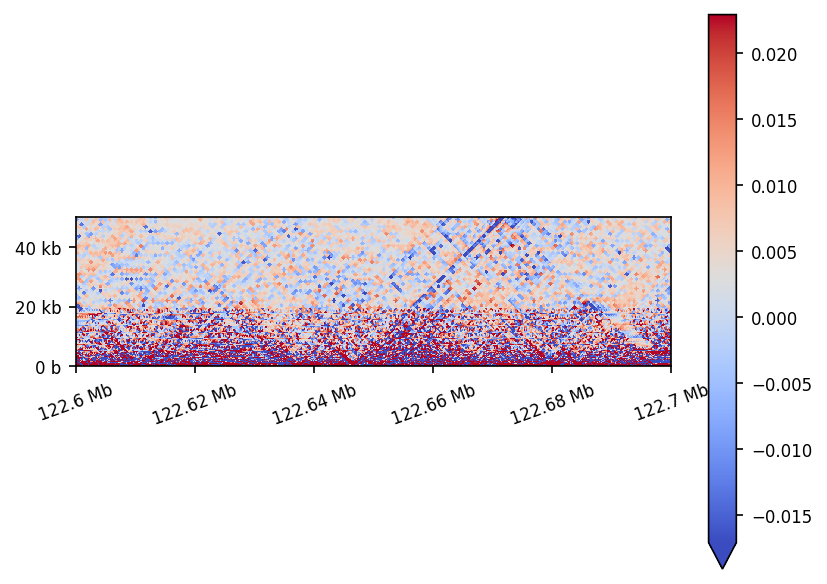

In [10]:
from maxentnuc.simulation.upper_triangular import triu_to_full

name = 'nanog'
alpha = f"{os.path.dirname(prod[name]['config'])}/0{prod[name]['iteration']}_alpha.npy"
alpha = np.load(alpha)
alpha = triu_to_full(alpha)
alpha = ContactMap(alpha, chrom, start, end, 200)

c = np.median(alpha.contact_map)
v = 0.02
f, ax = plot_horizontal_with_colors(alpha, vmin=c-v, vmax=c+v, cmap='coolwarm', extend='both', log_norm=False)
plt.savefig('img/overview_alpha.pdf')
plt.show()

f, ax = plt.subplots()
alpha.plot_contact_map_horizontal(ax=ax, depth=end-start, vmin=c-v, vmax=c+v, cmap='coolwarm', log_norm=False)
plt.xlim(122_600_000, 122_700_000)
plt.ylim(0, 50_000)
plt.show()